In [113]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

plt.style.use('fivethirtyeight')

#import data
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
display(df.head())

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [61]:
#explore data
display(df.head())
display(df.columns)
display(df.info())
df.isnull().sum()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


None

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [29]:
def mean_absoulte_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)


In [58]:
#method that cleans data and drops unneccessary columns
def clean_df(df):
    return(df.assign(dt=lambda df_: pd.to_datetime(df_['dt'])
                    )
           .loc[(df['Country'] == 'Suriname') & (df['dt'] >= '1915-01-01')] #filter data van Suriname vanaf 1915
           .drop(columns= ['AverageTemperatureUncertainty']) #drop ongebruikte kolom
           .rename(columns={'dt':'Year'})
           .set_index('Year') # zet datum als index
           .resample('MS')
           .interpolate(method = 'time')
           .dropna()
          )

In [59]:
#call method and display cleaned version
df_clean = clean_df(df)
display(df_clean.head())

,AverageTemperature,Country
Year,,
1915-01-01,25.478,Suriname
1915-02-01,25.554,Suriname
1915-03-01,26.447,Suriname
1915-04-01,26.247,Suriname
1915-05-01,26.382,Suriname


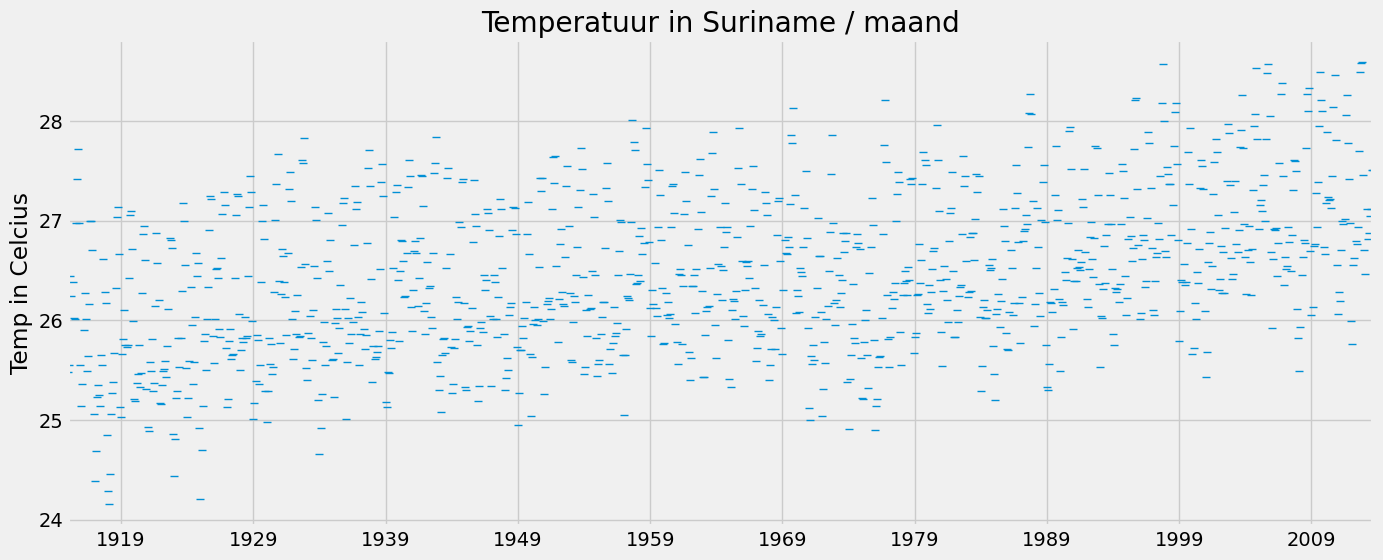

In [37]:
(df_clean
    .plot(
        figsize=(15, 5),
        style='_',
        title='Temperatuur in Suriname / maand',
        legend=False,
        xlabel='',
        ylabel='Temp in Celcius'
    )
)
plt.show()

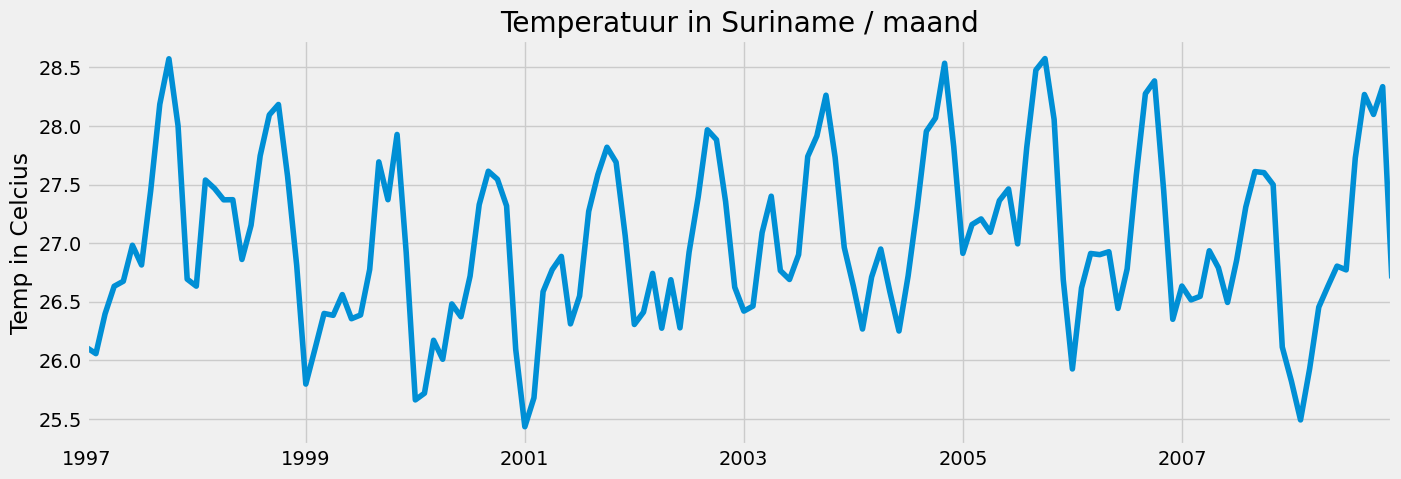

In [44]:
(df_clean
    .loc[
        (df_clean.index.year.isin(list(range(1997, 2009))))
    ]
    .plot(
        figsize= (15, 5),
        style= '-',
        title= 'Temperatuur in Suriname / maand',
        legend= False,
        xlabel= '',
        ylabel= 'Temp in Celcius'
    )
)

plt.show()

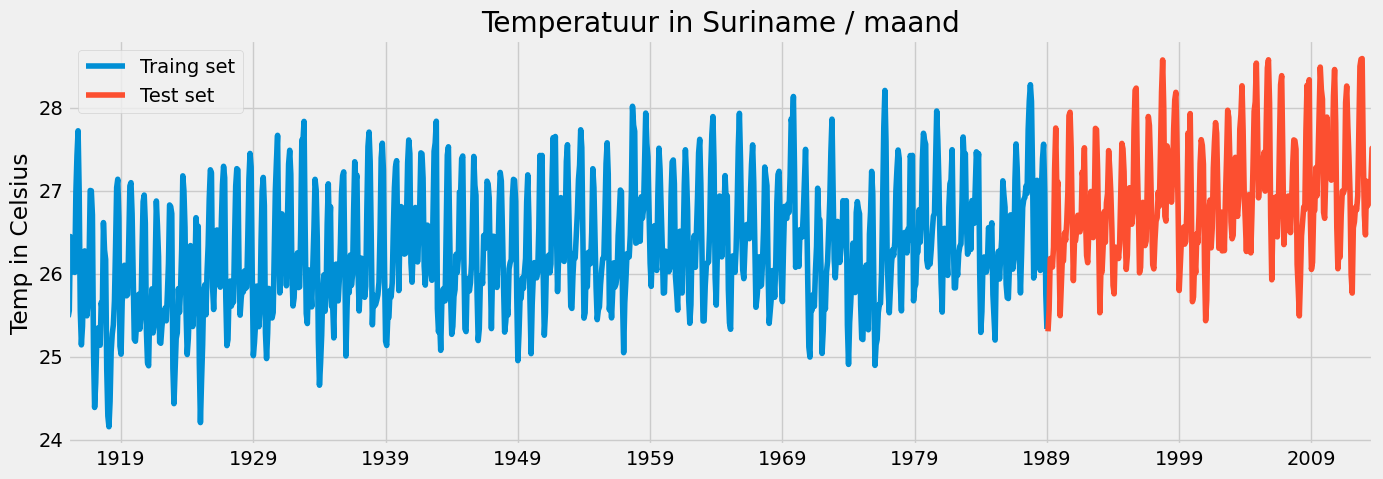

In [38]:
num_train = round(len(df_clean) * 0.75)

train = df_clean.iloc[:num_train]
test = df_clean.iloc[num_train:]

fig, ax= plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Test set')

ax.set_title('Temperatuur in Suriname / maand')
ax.set_xlabel('')
ax.set_ylabel('Temp in Celsius')
ax.legend(['Traing set', 'Test set'])
plt.show()